In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import plotly.express as px
import cufflinks as cf
from  plotly.offline import plot

from sklearn.utils import class_weight

In [2]:
# importing class object that I created
import sys  
sys.path.insert(0, '../src/')
import utils

In [3]:
tools = utils.tools() # create object

In [4]:
epi_data_df = tools.readfile('../data/processed/epi_vector.h5')
epi_data_df = tools.df

## Helper functions

In [5]:
epi_data_df.shape

(34626, 17972)

In [6]:
def countTags(sample_df):
    # Get count of tags

    c = Counter()  
    sample_df["tags"].apply(lambda x: c.update(x))
    # store tag count in df
    count = pd.DataFrame()
    count['tags_count'] = [c[i] for i in c]
    count['tag'] = [i for i in c]
    count = count.sort_values(by='tags_count',ascending=False)

    # delete row with value < n
    indexNames = count[ count['tags_count'] <= 30 ].index

    # Delete these row indexes from dataFrame
    count.drop(indexNames , inplace=True)
    return count


In [7]:
def getallergyTags(count):
    # look for ### Free tags
    count['allergy_tags'] = count['tag'].str.endswith('Free')

    allergy_df = count[count['allergy_tags'] == True]
    return allergy_df

In [8]:
# Create column in sample_df for allergy tags
def addallergytoDF(allergy_df,df):
    for i in allergy_df.tag:
        df[i] = [i in tags for tags in df.tags]
    return df

In [9]:
# I manually took out tags that are not recipe ingredients. And clean input. 
# Uncomment below if  cuisine type is needed
def loadCuisineType():
    cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
    cuisinetype = cuisinetype.transpose()
    cuisinetype = np.array(cuisinetype[0])
    cuisinetype = [x.replace('\'','') for x in cuisinetype]
    cuisinetype = [x.replace('[','') for x in cuisinetype]
    cuisinetype = [x.replace(']','') for x in cuisinetype]
    cuisinetype = [x.lstrip() for x in cuisinetype]
    # print(cuisinetype)
    
    # Uncomment below if states are needed

    states = pd.read_csv('states.csv',header=None)
    states = states.transpose()
    states = np.array(states[0])
    states = [x.lstrip() for x in states]
    # print(states)
    
    # Uncomment below if usa_cuisine is needed

    city = pd.read_csv('usa_city.csv',header=None)
    city = city.transpose()
    city = np.array(city[0])
    city = [x.replace('\'','') for x in city]
    city = [x.replace('[','') for x in city]
    city = [x.replace(']','') for x in city]
    city = [x.lstrip() for x in city]
    usa_cuisine =states+city
    # print(usa_cuisine)
    
    non_usa_cuisine = []
    for i in cuisinetype:
        if i not in usa_cuisine:
            non_usa_cuisine.append(i)
    return usa_cuisine,non_usa_cuisine
    

In [10]:
def addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine):
    tags_value=[]
    for tags in sample_df['tags']:
        if(set(tags).intersection(usa_cuisine)):
            tags_value.append(1)
            continue
        else:
            if(set(tags).intersection(non_usa_cuisine)):
                tags_value.append(0)
            else:
                tags_value.append(2)
    sample_df['usa_cuisine'] = tags_value
    return sample_df

In [11]:
# Drop column with all zeros
def dropZeroColumns(sample_df):
    sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
    return sample_df

In [12]:
def deleterows(df,column,value1,value2,yes):
    if(yes): # deleted row based on two values
        df = df.drop(df[df[column] == value1].index)
        df = df.drop(df[df[column] == value2].index)
    else:
        df = df.drop(df [df[column] == value1].index)
    return df

In [13]:
# drop not relevent columns and drop rest of allergy column except one you are analyzing
def dropAllergyColumn(sample_df,allergy_col):
    sample_df = sample_df.drop(columns=['avg_rating','best_rating','prepare_again_rating','num_reviews'],axis=0)

    sample_df = sample_df.drop(columns=allergy_col,axis=0)

    return sample_df

In [14]:

def getTrianData(sample_df,data_column,label_column):
    '''Seperate data and label to classify, 
    X are attribute columns used to classify, Y is the label
    first delete all infinity values in data. It also drop columns that are not needed.'''
    sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
    data = sample_df.drop(columns=data_column, axis=1)
    label = sample_df[label_column]
    return data,label


In [15]:
class SVCmodel(object):
    def __init__(self):
        pass
    def getSupport(self,model):
        '''Indices of support vectors'''
        return model.support_
    def getClassWeight(self,model):
        '''Support vectors'''
        return model.class_weight_
    def getNsupport(self,model):
        '''# of support vector for each class'''
        return model.n_support_
    def getsupportcoef(self,model):
        '''related to support vector in the decision function.'''
        return model.dual_coef_
    def getfeaturesweight(self,model):
        '''weight assigned to the features'''
        return model.coef_
    def getintercept(self,model):
        '''constants in decision function'''
        return model.intercept_
    def getfitstatus(self,model):
        '''0 if correctly fitted, 1 otherwise(will raise warning)'''
        return model.fit_status_
    def getclasses(self,model):
        '''The class label'''
        return model.classes_
    def getprobA(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2]'''
        return model.probA_
    def getprobB(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2].
        If probability=True, it corresponds to the parameters 
        learned in Platt scaling to produce probability estimates 
        from decision values. If probability=False, it’s an empty array. 
        Platt scaling uses the logistic function 
        1 / (1 + exp(decision_value * probA_ + probB_)) 
        where probA_ and probB_ are learned from the dataset 
        '''
        return model.probA_
    def getclassweight(self,model):
        '''multipliers of parameter C for each class.'''
        return model.class_weight_
    def getshapefit(self,model):
        return model.shape_fit_

## Data Preparation for Classification

In [16]:
# Cuisine Types: usa_cuisine ==> 1, non_usa_cuisine ==> 1, no_tags ==> 2
c = countTags(epi_data_df)
usa_cuisine,non_usa_cuisine = loadCuisineType()
allergy_tags = getallergyTags(c)
sample_df = epi_data_df.head(10000)
sample_df = addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine)
cuisine_df = sample_df
sample_df = addallergytoDF(allergy_tags,sample_df)
sample_df = dropZeroColumns(sample_df)


In [49]:
count1 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 1]) # true
count2 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 0]) # false
count3 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 2]) # NA
print("Neither USA Cuisine or non-USA Cuisine: ",count3)
print("USA Cuisine: ",count1)
print("Non-USA Cuisine: ",count2)

Neither USA Cuisine or non-USA Cuisine:  9537
USA Cuisine:  348
Non-USA Cuisine:  115


In [18]:
drop_column = ['avg_rating','best_rating','prepare_again_rating','num_reviews','Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free','usa_cuisine','tags','title']
label_column = ['usa_cuisine']

copy1 = sample_df
copy2 = sample_df
usa_tag_df = deleterows(copy1,'usa_cuisine',2,'',True)
no_cuisine_tag_df = deleterows(copy2,'usa_cuisine',1,0,False)

corr_data,corr_label = getTrianData(usa_tag_df,drop_column,label_column)
test_data,test_label = getTrianData(no_cuisine_tag_df,drop_column,label_column)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [19]:
test_data.head(2)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,ziti pasta,zucchini,"zucchini (about 5 medium), slice thin",zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
test_label.head(2)

,usa_cuisine
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,2
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,2


## Naive Bayes Classifier

In [21]:

# # create a guassian classifier
bayes_model = GaussianNB()
bayes_model.fit(corr_data,corr_label)
print(bayes_model.epsilon_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



7.727470203912951e-06


In [22]:
bayes_model.predict(corr_data.iloc[0:2])

array([1, 0])

In [23]:
results = bayes_model.predict(test_data)

In [24]:
print(results)

[1 1 1 ... 0 0 1]


## Support Vector Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Below website gives good explaination on reading result from SVC

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

### Fit model without weights

Referenced example from this link: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [25]:
C = 1
svc = svm.SVC(gamma=0.1,kernel='linear', C=C).fit(corr_data.iloc[:1000], corr_label[:1000]) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [91]:
result = SVCmodel()
result.getClassWeight(svc)

array([1., 1.])

In [92]:
predict = []
predict.append(svc.predict(corr_data.iloc[0:2]))

In [93]:
svc

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [94]:
classes = result.getclasses(svc)
classes

array([0, 1])

In [95]:
class_weight = result.getClassWeight(svc)
class_weight

array([1., 1.])

In [96]:
bayes_model.predict(corr_data.iloc[0:2])

array([1, 0])

### Fit model with weights

#### Calculate Weight

* sample_weight is to be applied to individual samples (rows in your data). So the length of sample_weight must match the number of samples in your X.

* class_weight is to make the classifier give more importance and attention to the classes. So the length of class_weight must match the number of classes in your targets.

In [61]:
total = count1 + count2
cal_w = [count1/total,count2/total]
cal_w = [{0:cal_w[1],1:cal_w[0]},{0:cal_w[1],1:cal_w[0]}]
cal_w

[{0: 0.24838012958963282, 1: 0.7516198704103672},
 {0: 0.24838012958963282, 1: 0.7516198704103672}]

Example of computing class_weight

https://programtalk.com/python-examples/sklearn.utils.class_weight.compute_class_weight/

In [76]:
y = corr_label[:1000].values.tolist()
y = np.where(y=='[','',y)#[x.replace('[','') for x in y]
# y = [x.replace(']','') for x in y]

In [77]:
y

array([['1'],
       ['0'],
       ['0'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
      

In [67]:
y = corr_label[:1000].values.tolist()
classes = np.unique(y)
class_weight.compute_class_weight('balanced',classes,y)

TypeError: unhashable type: 'list'

In [88]:
corr_label.usa_cuisine = corr_label.usa_cuisine.apply(int)

In [90]:
w_svc = svm.SVC(gamma=0.1,class_weight={0:3},probability=True)
w_svc.fit(corr_data.iloc[:1000], corr_label[:1000])#,sample_weight=cal_w) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVC(C=1.0, cache_size=200, class_weight={0: 3}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [97]:
w_svc.predict(corr_data.iloc[0:2])

array([1, 0])

In [98]:
w_svc.classes_

array([0, 1])

In [99]:
weights = w_svc.class_weight_
weights

array([3., 1.])

In [100]:
feature_weight = result.getfeaturesweight(svc)
# feature_weight = [x for x in feature_weight if x > 0.0]
# np.where(feature_weight > 0)
feature_weight.shape

(1, 7299)

In [ ]:
predict_result = w_svc.predict(test_data)

## Not Used Code

In [39]:
# uncomment below lines to replace column with number greater than 0 to 1 to make it binary.
# columns = ['avg_rating','best_rating','worst_rating','prepare_again_rating','num_reviews','total_time', 'tags', 'title']
# df = sample_df.copy()
# for col in sample_df.columns:
#     if col not in columns:
#         df.loc[df[col] > 0, col] = 1
# df.head(25)

In [40]:
# len(sample_df[["Breakfast" in x for x in sample_df.tags]])

In [41]:
# Uncomment below if need to encode data into unique value 


# from sklearn import preprocessing
# # label encoder
# le = preprocessing.LabelEncoder()

# # Converting string labels into numbers
# label = le.fit_transform(Y) # 0 ==> False, 1 ==> True
# label

# Uncomment below if need to convert X data into encoder and turn it into tuple list
#data.apply(le.fit_transform)
#data = [tuple(r) for r in data.values.tolist()]

In [42]:
# uncomment below if need to look for inf value in data 
# for col in X.columns:
#     print(X.loc[X[col] > 100000, col])

### Example from Sklearn Website

https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html

Automatically created module for IPython interactive environment
[1.04855297 1.42001794 1.70627019 1.9507754  0.50965218 0.4380743
 1.25279536 0.77749036 1.61389785 3.1911042  0.89546656 0.3869025
 0.51080514 1.18063218 0.02818223 2.14165935 0.33258611 1.51235949
 3.17161047 1.81370583]


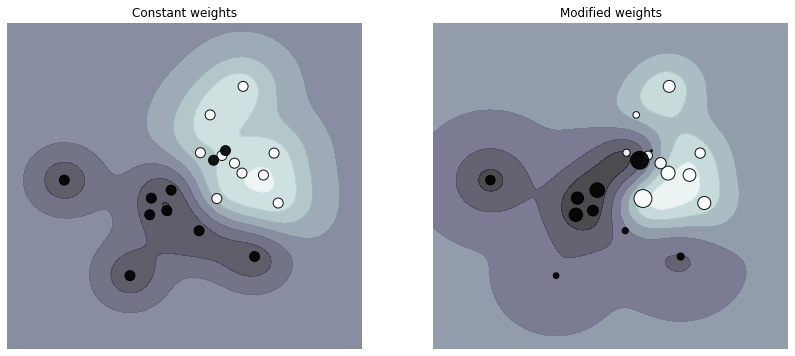

In [48]:
print(__doc__)

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights
print(sample_weight_last_ten)
# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()

In [44]:
# a = -class_weight[0] / class_weight[1]

# xx = np.linspace(0,50)
# yy = a * xx - feature_weight[0].max() / class_weight[1]
# print(xx.min(),yy.max())
# h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

# plt.scatter(x, y,c=y)
# plt.ylim(yy.min(),50)
# plt.xlim(xx.min(),50)
# plt.legend()
# plt.show()

In [45]:

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import svm, datasets

# # import some data to play with
# iris = datasets.load_iris()
# X = data.iloc[:1000, :100]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = label.iloc[:1000]

# h = .02  # step size in the mesh

# # we create an instance of SVM and fit out data. We do not scale our
# # data since we want to plot the support vectors
# C = 1.0  # SVM regularization parameter
# svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
# poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
# lin_svc = svm.LinearSVC(C=C).fit(X, y)

# # create a mesh to plot in
# x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
# y_min, y_max = X.iloc[:, 100].min() - 1, X.iloc[:, 100].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # title for the plots
# titles = ['SVC with linear kernel',
#           'LinearSVC (linear kernel)',
#           'SVC with RBF kernel',
#           'SVC with polynomial (degree 3) kernel']


# for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     plt.subplot(2, 2, i + 1)
#     plt.subplots_adjust(wspace=0.4, hspace=0.4)

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

#     # Plot also the training points
#     plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
#     plt.xlabel('Sepal length')
#     plt.ylabel('Sepal width')
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())
#     plt.xticks(())
#     plt.yticks(())
#     plt.title(titles[i])

# plt.show()

In [46]:
# plot_decision_function(clf,clf.class_weight_,axes[0],'SVC without weights')

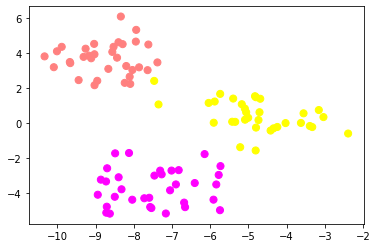

In [47]:
from sklearn.datasets.samples_generator import make_blobs 

x,y = make_blobs(n_samples=100,centers=3,n_features=3)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring'); 
plt.show()  